<a href="https://colab.research.google.com/github/bheinri2/DL_Speech_Recognition/blob/main/Preprocessing_training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa #, librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/jbuchner/synthetic-speech-commands-dataset")

Skipping, found downloaded files in "./synthetic-speech-commands-dataset" (use force=True to force download)


In [ ]:
od.download("https://www.kaggle.com/joserzapata/free-spoken-digit-dataset-fsdd")

100%|██████████| 15.5M/15.5M [00:00<00:00, 112MB/s] 

In [ ]:
FILE_DIR_1 = "/content/free-spoken-digit-dataset-fsdd/recordings"
FILE_DIR_2 = "/content/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset"


#### dataset 1: spoken digits

In [ ]:
# Load spoken digits audio files into padded numpy arrays and store in a list
# Takes 1 min 13 sec
max_length = 0
#audio_signals_1 = []
for root, dirs, files in os.walk(FILE_DIR_1):
  for ffile in files:
    #print(ffile)
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    max_length = max(audio_time_series.size, max_length)
    
audio_signals_1 = []
labels_1 = []
for root, dirs, files in os.walk(FILE_DIR_1):
  for ffile in files:
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    padding = max_length - audio_time_series.size
    padded = np.pad(audio_time_series, (0, padding), 'constant', 
                    constant_values=(0, 0))
    #print(padded)
    #print(padded.size)
    audio_signals_1.append(padded)
    y_num = int(str(ffile)[0])
    labels_1.append(y_num)
    #print(sr)

In [ ]:
test = np.array(labels_1)
test.shape

(3000,)

In [ ]:
import IPython.display as ipd
n = 503
print(labels_1[n])
#y, sr = librosa.load(audio_signals_1[n])
ipd.Audio(audio_signals_1[n],rate=sr)

9


#### dataset 2: spoken words

In [ ]:
from random import sample

In [ ]:
f_names = [] # list of file names of samples to take
for root, dirs, files in os.walk(FILE_DIR_2):
  for f in files:
    file_path = os.path.join(root, f)
    f_names.append(file_path)

In [ ]:
f_names = np.array(f_names)
f_names.shape

(41849,)

In [ ]:
max_length = 0
audio_signals_2 = []
labels_2 = []
for i in range(0, len(f_names), 5):
  f = f_names[i]
  audio_time_series, sr = librosa.load(f)
  labels_2.append(f.split('/')[5]) # appends the name of the lowest level directory for each file (which is each files corresponding label)
  audio_signals_2.append(audio_time_series)
  max_length = max(audio_time_series.size, max_length)

In [ ]:
test2 = np.array(labels_2)
test2.shape

(8370,)

###### extra stuff

In [ ]:

# This didn't finish after 20 mins
max_length = 0
audio_signals_2 = []
labels_2 = []
#classes = []
for root, dirs, files in os.walk(FILE_DIR_2):
  #for dir in dirs:
  #  classes.append(str(dir))
  for ffile in files:
    file_path = os.path.join(root, ffile)
    #print(file_path.split('/')[5])
    labels_2.append(file_path.split('/')[5]) # appends the name of the lowest level directory for each file (which is each files corresponding label)
    audio_time_series, sr = librosa.load(file_path)
    audio_signals_2.append(audio_time_series)
    max_length = max(audio_time_series.size, max_length)

# padding each audio signal
for signal in audio_signals_2:
  padding = max_length - signal.size
  padded_signal = np.pad(signal, (0,padding), 'constant', 
                         constant_values=(0,0))

In [ ]:
# This didn't finish after 20 mins
max_length = 0
audio_signals_2 = []
labels_2 = []
#classes = []
for root, dirs, files in os.walk(FILE_DIR_2):
  #for dir in dirs:
  #  classes.append(str(dir))
  for ffile in files:
    file_path = os.path.join(root, ffile)
    #print(file_path.split('/')[5])
    labels_2.append(file_path.split('/')[5]) # appends the name of the lowest level directory for each file (which is each files corresponding label)
    audio_time_series, sr = librosa.load(file_path)
    audio_signals_2.append(audio_time_series)
    max_length = max(audio_time_series.size, max_length)

# padding each audio signal
for signal in audio_signals_2:
  padding = max_length - signal.size
  padded_signal = np.pad(signal, (0,padding), 'constant', 
                         constant_values=(0,0))
'''    
audio_signals_1 = []
for root, dirs, files in os.walk(FILE_DIR_2):
  for ffile in files:
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    padding = max_length - audio_time_series.size
    padded = np.pad(audio_time_series, (0, padding), 'constant', 
                    constant_values=(0, 0))
    #print(padded)
    #print(padded.size)
    audio_signals_1.append(padded)
    #print(sr)
'''

Streaming output truncated to the last 5000 lines.
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
sheila
shei

"    \naudio_signals_1 = []\nfor root, dirs, files in os.walk(FILE_DIR_2):\n  for ffile in files:\n    file_path = os.path.join(root, ffile)\n    audio_time_series, sr = librosa.load(file_path)\n    padding = max_length - audio_time_series.size\n    padded = np.pad(audio_time_series, (0, padding), 'constant', \n                    constant_values=(0, 0))\n    #print(padded)\n    #print(padded.size)\n    audio_signals_1.append(padded)\n    #print(sr)\n"

### Converting samples to mel-spectrograms ###

#### Helper Functions ####

In [ ]:
# handles individual signal conversion
def signal_to_mel_spectrogram(signal, hop_length, n_fft):
  ''' converts a given audio signal to a mel spectrogram
  parameters: 
    signal: self-explanatory
    hop_length: number of samples to shift between transformations
    n_fft: number of samples taken per fast fourier transformations
  '''
  # Short-time Fourier Transformation on our audio data
  audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
  # gathering the absolute values for all values in our audio_stft 
  spectrogram = np.abs(audio_stft)
  # Converting the amplitude to decibels
  return librosa.amplitude_to_db(spectrogram)

In [ ]:
# plots converted spectrograms (NOTE: for testing purposes)
def plot_spectro(spectrogram, sample_rate, hop_length):
  # Plotting the short-time Fourier Transformation
  plt.figure(figsize=(20, 5))
  # Using librosa.display.specshow() to create our spectrogram
  librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='hz', hop_length=hop_length, cmap='magma')
  plt.colorbar(label='Decibels')
  plt.title('Spectrogram (dB)', fontdict=dict(size=18))
  plt.xlabel('Time', fontdict=dict(size=15))
  plt.ylabel('Frequency', fontdict=dict(size=15))
  plt.show()

### More Helper functions

In [ ]:
def split_data(X, Y, t_ratio=0.3):
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:t_split],       Y[0:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_test, Y_test

### Free-spoken Digit dataset conversion: ### 

In [ ]:
#### BATCH CONVERSION for first (faster) set ####
### TODO: figure out best values for n_fft, hop_length
n_fft = 2048 # number of samples in a window per fft
hop_length = 512 # amount of samples we are shifting after each fft
mel_spectrograms_1 = [] # list to store each converted signal

### actual conversion process
for signal in audio_signals_1:
  ms = signal_to_mel_spectrogram(signal, hop_length, n_fft)
  mel_spectrograms_1.append(ms)

In [ ]:
### Final X,Y data:
# X = mel_spectrograms_1
# Y = labels_1

#print(mel_spectrograms_1[4].shape)

mel_spectrograms_1 = np.array(mel_spectrograms_1)
labels_1 = np.array(labels_1)
print(mel_spectrograms_1.shape)
print(labels_1.shape)


(3000, 1025, 99)
(3000,)


In [ ]:
'''
def split_data(X, Y, v_ratio=0.2, t_ratio=0.1):
  v_split = int(X.shape[0]*(1-v_ratio-t_ratio))
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:v_split],       Y[0:v_split]
  X_valid, Y_valid  = X[v_split:t_split], Y[v_split:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test '''

In [ ]:
def split_data(X, Y, t_ratio=0.3):
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:t_split],       Y[0:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_test, Y_test

In [ ]:
### creating X_train/X_test, Y_train/Y_test data splits
X_train, y_train, X_test, y_test = split_data(mel_spectrograms_1, labels_1, t_ratio=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2250, 1025, 99)
(2250,)
(750, 1025, 99)
(750,)


In [ ]:
'''
from sklearn.preprocessing import StandardScaler

### Standardizing data
scaler = StandardScaler().fit(X_train) # mean, variance 
X_train = scaler.transform(X_train)
#X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)
'''

'\nfrom sklearn.preprocessing import StandardScaler\n\n### Standardizing data\nscaler = StandardScaler().fit(X_train) # mean, variance \nX_train = scaler.transform(X_train)\n#X_valid = scaler.transform(X_valid)\nX_test  = scaler.transform(X_test)\n'

In [ ]:
### shuffling the data
shuf = np.arange(X_train.shape[0])
np.random.shuffle(shuf)
X_train = X_train[shuf]
y_train = y_train[shuf]

#### Model

In [ ]:
### Useful imports for defining our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
from tensorflow.keras.initializers import GlorotNormal, HeNormal # https://www.tensorflow.org/api_docs/python/tf/keras/initializers
from tensorflow.keras.callbacks import EarlyStopping # early stopping

from tensorflow.keras.utils import to_categorical

In [ ]:
# reshaping 3D tensors to 4D tensors for fully-connected layers
X_train = X_train.reshape(-1, 1025, 99, 1) # FIXME (batch, rows, columns, channels)
# 60000*28*28
# np.extend_dims(X_train, -1)
X_test = X_test.reshape(-1, 1025,99,1) # FIXME (batch, rows, columns, channels)

# it is in int8 format, the neural network requires float32, convert the arrays to float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

### converting Y_train/Y_test from explicit digits (0,...,9) to categorical (ex. 5 -> [0,0,0,0,0,1,0,0,0,0])
nb_classes=10
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [ ]:
### for testing purposes
digits = np.asarray(range(nb_classes))
print(Y_train[0].astype(np.int))

[0 0 0 1 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


##### Defining the model

In [ ]:

model = Sequential()
model.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(1025,99,1,)))
model.add(MaxPool2D()) 
model.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1021, 95, 6)       156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 510, 47, 6)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 506, 43, 16)       2416      
                                                                 
 flatten (Flatten)           (None, 348128)            0         
                                                                 
 dense (Dense)               (None, 10)                3481290   
                                                                 
Total params: 3,483,862
Trainable params: 3,483,862
Non-trainable params: 0
______________________________________________

In [ ]:
model.input

<KerasTensor: shape=(None, 1025, 99, 1) dtype=float32 (created by layer 'conv2d_input')>

##### Training

In [ ]:
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy') # Early stopping

In [ ]:
network_history = model.fit(X_train, Y_train, batch_size=128, 
                            epochs=10, verbose=1, validation_split=0.2, 
                            callbacks=[es])

Epoch 1/10
15/15 [==============================] - 111s 7s/step - loss: 6174.4355 - accuracy: 0.1006 - val_loss: 67.3051 - val_accuracy: 0.1578
Epoch 2/10
15/15 [==============================] - 110s 7s/step - loss: 31.8564 - accuracy: 0.1728 - val_loss: 8.5965 - val_accuracy: 0.2822
Epoch 3/10
15/15 [==============================] - 110s 7s/step - loss: 6.7239 - accuracy: 0.3400 - val_loss: 4.4896 - val_accuracy: 0.3467
Epoch 4/10
15/15 [==============================] - 109s 7s/step - loss: 3.4029 - accuracy: 0.4144 - val_loss: 2.4587 - val_accuracy: 0.4289
Epoch 5/10
15/15 [==============================] - 110s 7s/step - loss: 1.5715 - accuracy: 0.5867 - val_loss: 1.5286 - val_accuracy: 0.5467
Epoch 6/10
15/15 [==============================] - 110s 7s/step - loss: 0.8932 - accuracy: 0.7322 - val_loss: 1.2530 - val_accuracy: 0.6244
Epoch 7/10
15/15 [==============================] - 111s 7s/step - loss: 0.6776 - accuracy: 0.7911 - val_loss: 1.2327 - val_accuracy: 0.6222
Epoch 8/

##### Testing

In [ ]:
print(model.evaluate(X_test, Y_test))

24/24 [==============================] - 14s 583ms/step - loss: 1.4611 - accuracy: 0.7213
[1.4611189365386963, 0.7213333249092102]


In [ ]:
preds=model.predict(X_test)

In [ ]:
preds.shape

(750, 10)

In [ ]:
preds[0], Y_test[0]

(array([1.6704966e-07, 2.5066739e-02, 4.3493812e-15, 2.1458877e-08,
        2.1889854e-14, 9.7103363e-01, 1.6927829e-13, 5.1702703e-08,
        9.2043952e-18, 3.8993459e-03], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [ ]:
pred_labels=np.argmax(preds, axis=1)

In [ ]:
pred_labels[0]

5

##### Testing, continued (Confusion matrix)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
print(classification_report(np.argmax(Y_test, axis=1), pred_labels))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        74
           1       0.61      0.76      0.68        67
           2       0.56      0.79      0.66        63
           3       0.63      0.50      0.56        78
           4       0.74      0.74      0.74        76
           5       0.73      0.75      0.74        85
           6       0.76      0.82      0.79        79
           7       0.75      0.56      0.64        80
           8       0.81      0.82      0.82        73
           9       0.84      0.63      0.72        75

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.72       750
weighted avg       0.73      0.72      0.72       750



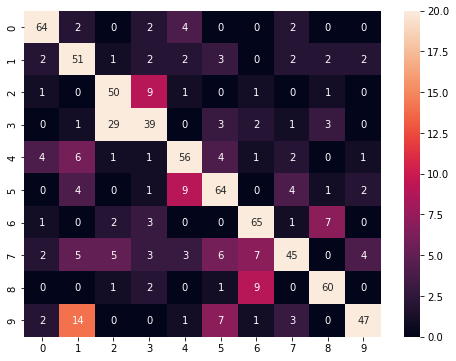

In [ ]:
conf = confusion_matrix(np.argmax(Y_test, axis=1), pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, fmt="d", vmax=20)

##### TODO - figure out how to convert mel_specs back to raw audio (to better see misclassifications)

### Synthetic Speech Commands dataset conversion: ###

In [ ]:
#### BATCH CONVERSION for second (slower) set ####
### TODO: figure out best values for n_fft, hop_length
n_fft = 2048 # number of samples in a window per fft
hop_length = 512 # amount of samples we are shifting after each fft
mel_spectrograms_2 = [] # list to store each converted signal

### actual conversion process
for signal in audio_signals_2:
  ms = signal_to_mel_spectrogram(signal, hop_length, n_fft)
  mel_spectrograms_2.append(ms)

In [ ]:
### Final X,Y data:
# X = mel_spectrograms_2
# Y = labels_2

#print(mel_spectrograms_2[4].shape)

mel_spectrograms_2 = np.array(mel_spectrograms_2)
labels_2 = np.array(labels_2)
print(mel_spectrograms_2.shape)
print(labels_2.shape)


(8370, 1025, 44)
(8370,)


In [ ]:
### shuffling the data
shuf = np.arange(mel_spectrograms_2.shape[0])
np.random.shuffle(shuf)
mel_spectrograms_2 = mel_spectrograms_2[shuf]
labels_2 = labels_2[shuf]

In [ ]:
classes_2 = list(set(labels_2))

# Next, we create character->index and index->character dictionaries for the one-hot encodings.
class_indices = dict((c, i) for i, c in enumerate(classes_2))
indices_class = dict((i, c) for i, c in enumerate(classes_2))
len(classes_2)

30

In [ ]:
y = np.zeros((mel_spectrograms_2.shape[0], len(classes_2)))
#y = np.zeros(8370, 30)
for i, c in enumerate(labels_2):
  y[i,class_indices[c]] = 1

In [ ]:
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [ ]:
import random
n = random.randrange(0,mel_spectrograms_2.shape[0])
y[n]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
### creating X_train/X_test, Y_train/Y_test data splits
X_train_2, y_train_2, X_test_2, y_test_2 = split_data(mel_spectrograms_2, y)
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(5859, 1025, 44)
(5859, 30)
(2511, 1025, 44)
(2511, 30)



#### model

In [ ]:
y_train_2[100]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# reshaping 3D tensors to 4D tensors for fully-connected layers
X_train_2 = X_train_2.reshape(-1, 1025, 44, 1) # FIXME (batch, rows, columns, channels)
# 60000*28*28
# np.extend_dims(X_train, -1)
X_test_2 = X_test_2.reshape(-1, 1025, 44, 1) # FIXME (batch, rows, columns, channels)

# it is in int8 format, the neural network requires float32, convert the arrays to float32
X_train_2 = X_train_2.astype("float32")
X_test_2 = X_test_2.astype("float32")


### converting Y_train/Y_test from explicit digits (0,...,9) to categorical (ex. 5 -> [0,0,0,0,0,1,0,0,0,0])
nb_classes_2=len(classes_2)
'''
Y_train_2 = to_categorical(y_train_2, nb_classes_2)
Y_test_2 = to_categorical(y_test_2, nb_classes_2)
'''

'\nY_train_2 = to_categorical(y_train_2, nb_classes_2)\nY_test_2 = to_categorical(y_test_2, nb_classes_2)\n'

In [ ]:
### for testing purposes
#words = np.asarray(range(nb_classes_2))
print(y_train_2[0].astype(np.int))

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


##### defining the model

In [ ]:
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model2 = Sequential()
model2.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(1025,44,1,)))
model2.add(MaxPool2D()) 
model2.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model2.add(Flatten())
model2.add(Dense(nb_classes_2, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1021, 40, 6)       156       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 510, 20, 6)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 506, 16, 16)       2416      
                                                                 
 flatten_1 (Flatten)         (None, 129536)            0         
                                                                 
 dense (Dense)               (None, 30)                3886110   
                                                                 
Total params: 3,888,682
Trainable params: 3,888,682
Non-trainable params: 0
____________________________________________

In [ ]:
model2.input

<KerasTensor: shape=(None, 1025, 44, 1) dtype=float32 (created by layer 'conv2d_2_input')>

##### training

In [ ]:
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy') # Early stopping

In [ ]:
network_history = model2.fit(X_train_2, y_train_2, batch_size=128, 
                            epochs=4, verbose=1, validation_split=0.2, # seems to start overfitting at epoch 5
                            callbacks=[es])

Epoch 1/10
37/37 [==============================] - 134s 4s/step - loss: 1374.3619 - accuracy: 0.0557 - val_loss: 11.1993 - val_accuracy: 0.2056
Epoch 2/10
37/37 [==============================] - 123s 3s/step - loss: 2.5026 - accuracy: 0.5705 - val_loss: 1.0164 - val_accuracy: 0.7312
Epoch 3/10
37/37 [==============================] - 126s 3s/step - loss: 0.2079 - accuracy: 0.9516 - val_loss: 0.7349 - val_accuracy: 0.7892
Epoch 4/10
37/37 [==============================] - 123s 3s/step - loss: 0.0245 - accuracy: 0.9964 - val_loss: 0.6847 - val_accuracy: 0.8157
Epoch 5/10
37/37 [==============================] - 123s 3s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.6937 - val_accuracy: 0.8191
Epoch 6/10
37/37 [==============================] - 124s 3s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6799 - val_accuracy: 0.8217
Epoch 7/10
37/37 [==============================] - 123s 3s/step - loss: 9.8830e-04 - accuracy: 1.0000 - val_loss: 0.6807 - val_accuracy: 0.8225
Epoch

#### Evaluation

In [ ]:
print(model2.evaluate(X_test_2, y_test_2))

79/79 [==============================] - 21s 264ms/step - loss: 0.7770 - accuracy: 0.8252
[0.7770309448242188, 0.8251692652702332]


In [ ]:
preds_2=model2.predict(X_test_2)

In [ ]:
preds_2.shape

(2511, 30)

In [ ]:
preds_2[0], y_test_2[0]

(array([9.4466068e-10, 1.7131695e-03, 2.6242121e-04, 1.6766613e-06,
        2.0943271e-05, 5.3212730e-06, 1.2477926e-08, 3.5396329e-01,
        1.9550975e-05, 3.3379820e-05, 2.3642344e-06, 1.0539663e-06,
        3.4618361e-03, 4.6373263e-04, 4.9078633e-05, 6.1810996e-09,
        6.2004185e-01, 3.3054137e-04, 1.9630657e-07, 1.2066868e-04,
        1.6451918e-02, 6.1622627e-06, 1.4820091e-03, 5.1292270e-10,
        2.0811378e-04, 2.3066608e-04, 1.1215787e-03, 3.1420640e-08,
        8.1238686e-06, 2.6184480e-07], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
pred_labels_2=np.argmax(preds_2, axis=1)

In [ ]:
pred_labels_2[0]

16

#### Evaluation cont (confusion matrix/misclassifications)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
pred_labels_2
pred_labels_2.shape

(2511,)

In [ ]:
print(classification_report(np.argmax(y_test_2, axis=1), pred_labels_2))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97        88
           1       0.80      0.92      0.85        83
           2       0.92      0.94      0.93       134
           3       1.00      0.90      0.95        99
           4       0.90      0.88      0.89        73
           5       0.55      0.68      0.61       123
           6       0.97      0.93      0.95        70
           7       0.79      0.75      0.77        81
           8       0.93      0.93      0.93        57
           9       0.90      0.96      0.93        83
          10       0.76      0.79      0.78        66
          11       0.88      0.81      0.84        70
          12       0.78      0.73      0.75        55
          13       0.76      0.73      0.75        60
          14       0.92      0.90      0.91        78
          15       0.49      0.49      0.49        51
          16       0.72      0.78      0.75        68
          17       0.88    

In [ ]:
print( "lowest performers:\n",
    indices_class[5], "\n",
    indices_class[15], "\n",
    indices_class[21], "\n", 
    indices_class[26]
)

lowest performers:
 on 
 no 
 one 
 go


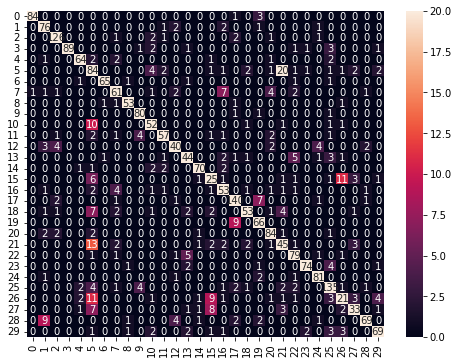

In [ ]:
conf_2 = confusion_matrix(np.argmax(y_test_2, axis=1), pred_labels_2)
plt.figure(figsize=(8,6))
sns.heatmap(conf_2, annot=True, fmt="d", vmax=20)

In [ ]:
# NOTE: LOTS of confusion between classes 5 ('on') and 21 ('one') (in both directions)